## Impact of Scalers
Comparing the effect of various scalers on the dataset (assuming with outliers)

In [128]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [159]:
# import dataset
df_audio = pd.read_csv("all_features.csv", index_col = 0)#.drop(['target', 'id'], axis = 1).fillna(0)
df_audio.describe()

,target,chroma 0 mean,chroma 0 std,chroma 1 mean,chroma 1 std,chroma 2 mean,chroma 2 std,chroma 3 mean,chroma 3 std,chroma 4 mean,...,band_discontinuity_amplitudes.mean,band_discontinuity_amplitudes.stdev,band_discontinuity_amplitudes.skew,band_clicks_instances,band_clicks_starts.mean,band_clicks_starts.stdev,band_clicks_starts.skew,band_clicks_durations.mean,band_clicks_durations.stdev,band_clicks_durations.skew
count,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,...,2073.000000,2073.000000,2073.000000,2073.0,2073.0,2073.0,2073.0,2073.0,2073.0,2073.0
mean,0.523878,0.262098,0.261939,0.263839,0.259772,0.258560,0.263144,0.278356,0.283789,0.274692,...,0.000947,0.000353,1.163065,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.499550,0.043021,0.039475,0.038453,0.040393,0.042919,0.044011,0.046592,0.049395,0.044113,...,0.003347,0.003024,16.656119,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.057275,0.084539,0.066501,0.060173,0.039023,0.059576,0.036366,0.056006,0.056022,...,0.000000,0.000000,-1.794639,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.234699,0.236308,0.241029,0.235723,0.231305,0.235139,0.250700,0.253203,0.247654,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.000000,0.259401,0.260821,0.263791,0.258942,0.257597,0.260100,0.278015,0.280652,0.276044,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,0.286029,0.285040,0.287363,0.284843,0.286737,0.290164,0.304822,0.311824,0.302185,...,0.001762,0.000145,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,0.517946,0.443696,0.441107,0.441698,0.406540,0.497528,0.610958,0.440034,0.493273,...,0.135944,0.095201,402.231293,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
# determine columns with most outliers
Q1 = df_audio.quantile(0.25)
Q3 = df_audio.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_audio < (Q1 - 1.5 * IQR)) | (df_audio > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False)

outliers.head()

band_discontinuity_locations.skew         999
band_discontinuity_amplitudes.skew        511
band_lowlevel.silence_rate_30dB.skew      468
band_discontinuity_instances              424
band_lowlevel.silence_rate_60dB.median    419
dtype: int64

In [168]:
# taking the 2 columns with the most outliers
X, y_full = df_audio[[outliers.keys()[0], outliers.keys()[1]]], df_audio['target']

In [162]:
distributions = [
    ('Unscaled data', X),
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(X)),
    ('Data after power transformation (Box-Cox)',
     PowerTransformer(method='box-cox').fit_transform(X)), # N/A, strictly positive vals allowed
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('Data after sample-wise L2 normalizing',
        Normalizer().fit_transform(X)),
]

ValueError: could not convert string to float: '572-2040'

In [163]:
# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, 'plasma_r', cm.hot_r)

def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)

In [164]:
def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

In [165]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(axarr[0], X, y, hist_nbins=200,
                      x0_label=outliers.keys()[0],
                      x1_label=outliers.keys()[1],
                      title="Full data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], X[non_outliers_mask], y[non_outliers_mask],
                      hist_nbins=50,
                      x0_label=outliers.keys()[0],
                      x1_label=outliers.keys()[1],
                      title="Zoom-in")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of y')

## Original data

TypeError: '(slice(None, None, None), 0)' is an invalid key

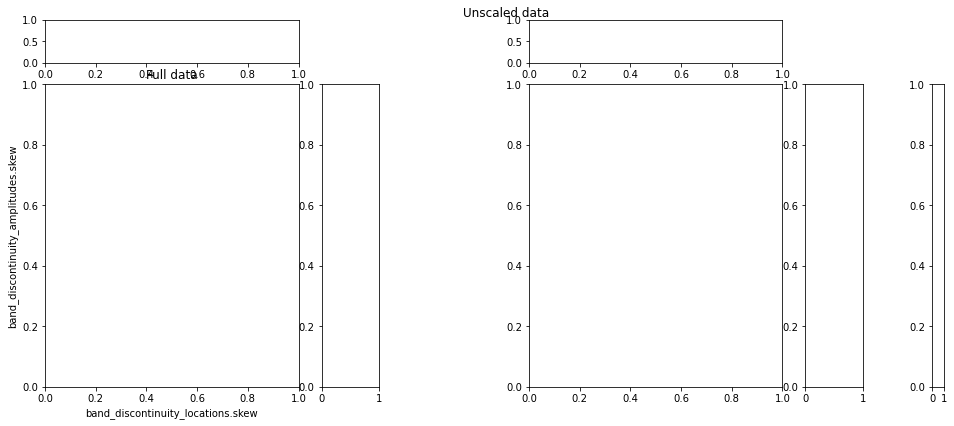

In [166]:
make_plot(0)

## StandardScalar

`StandardScaler` removes the mean and scales the data to unit variance. But outliers can greatly impact the calculation of the mean and standard deviation therefore cannot guarantee balanced feature scales in the presence of outliers. From https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html, `StandardScaler` cannot guarantee balanced feature scales in the presence of outliers.

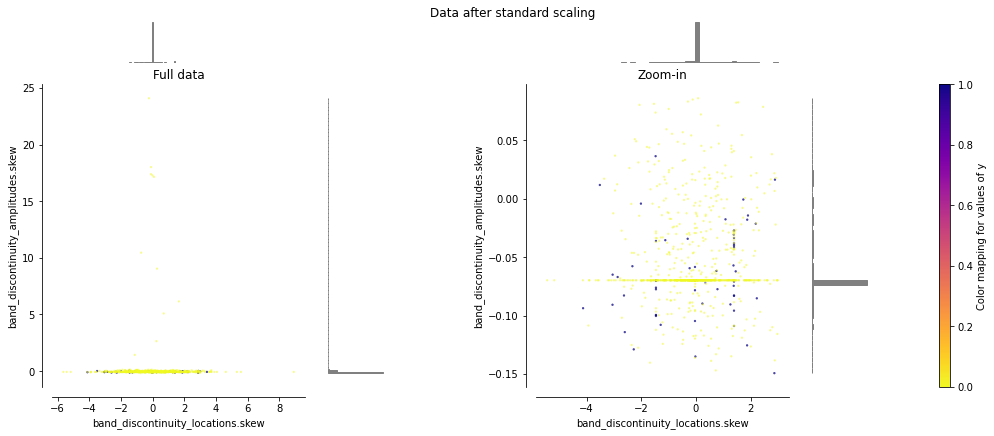

In [167]:
make_plot(1)

## MinMaxScaler
`MinMaxScaler` rescales the dataset to the range [0, 1], but is still very sensitive to the presence of outliers (like `StandardScaler`)

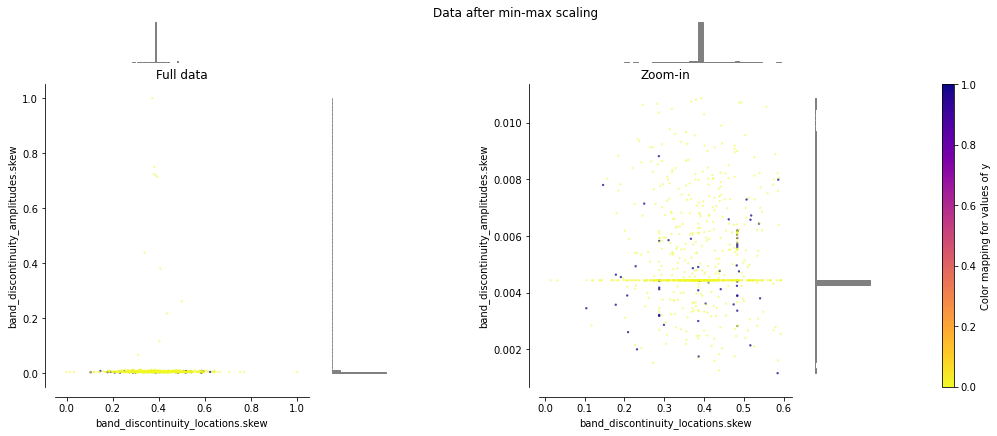

In [137]:
make_plot(2)

## MaxAbsScaler
Takes the absolute value of the data before rescaling it to [0, 1]. Like `MinMaxScaler`, it is also sensitive to outliers. 

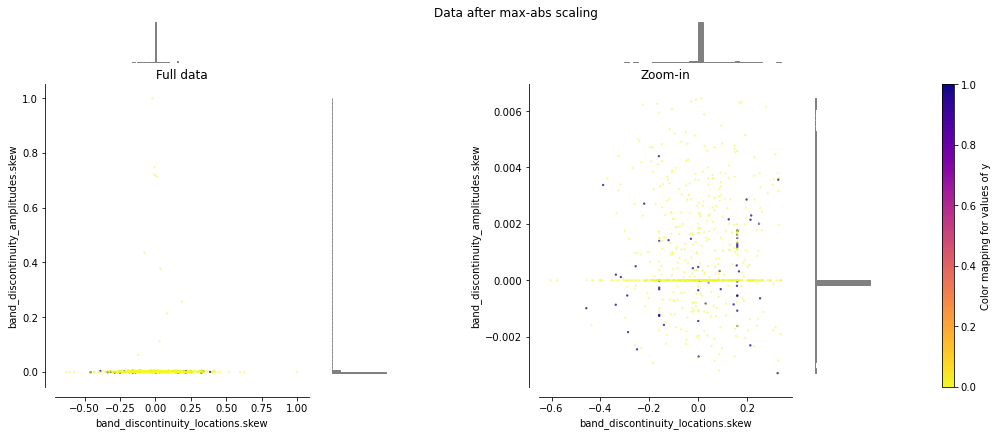

In [138]:
make_plot(3)

## RobustScaler
Centering and scaling statistics are based on a linear relationship to percentiles, and can therefore better handle large outliers. Outliers are still present in the transformed data.

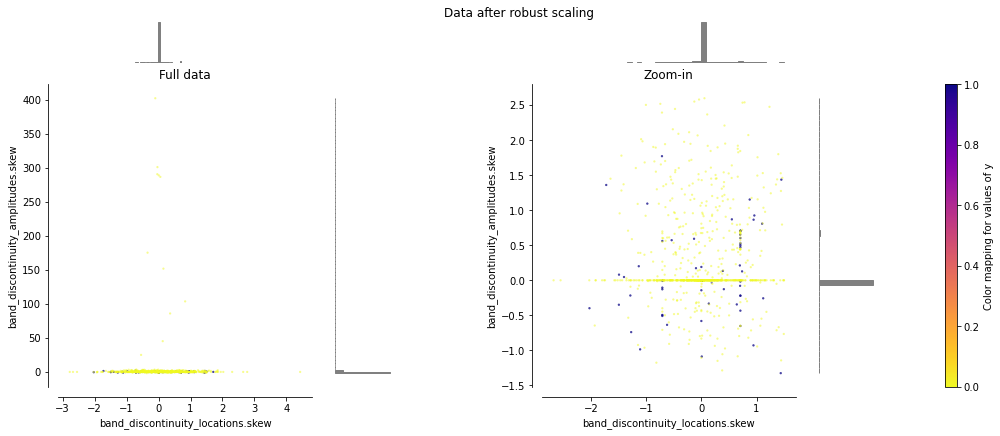

In [139]:
make_plot(4)

## PowerTransformer

Applies a transform to each feature to make the data more Gaussian-like. The `PowerTransformer` implements two transforms: the Box-Cox applies to strictly positive data whereas the Yeo-Johnson can apply to any signed data. In our case, the Yeo-Johnson tranformation is preferred.

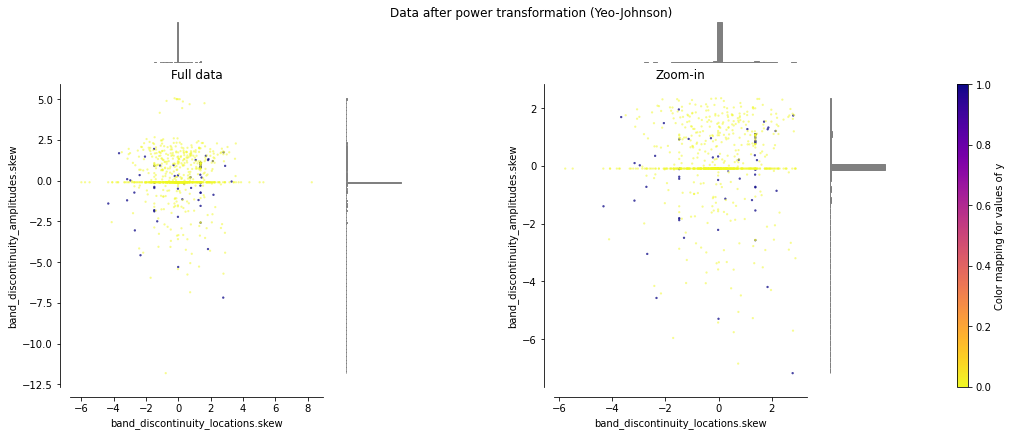

In [140]:
make_plot(5) # Yeo-Johnson
# make_plot(6) # Box-Cox # NA, strictly postive vals allowed

## QuantileTransformer (Gaussian)
Has an additional `output_distribution` parameter to match a Gaussian distribution instead of a uniform distribution. "Note that this non-parametetric transformer introduces saturation artifacts for extreme values."

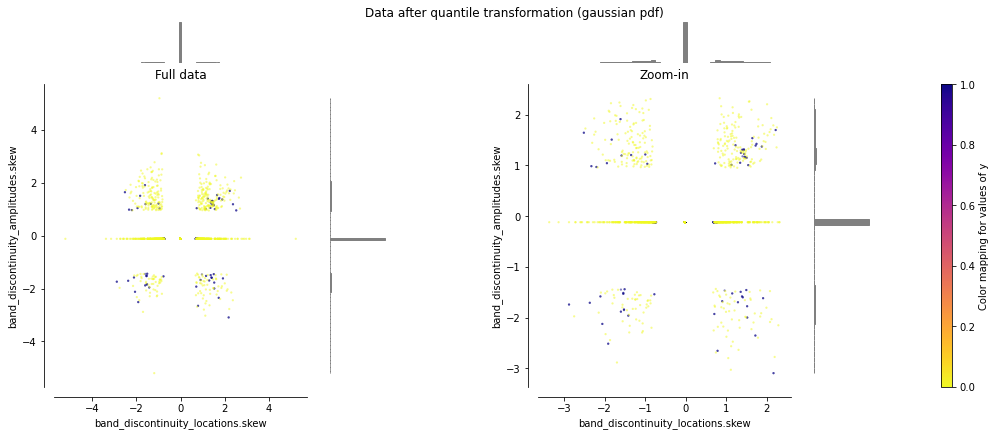

In [141]:
make_plot(6)

## QuantileTransformer (Uniform)
Applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform distribution. In this case, all the data will be mapped in the range [0, 1]. The outliers cannot be distinguished anymore from the inliers.

Contrary to `RobustScaler`, `QuantileTransformer` will automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

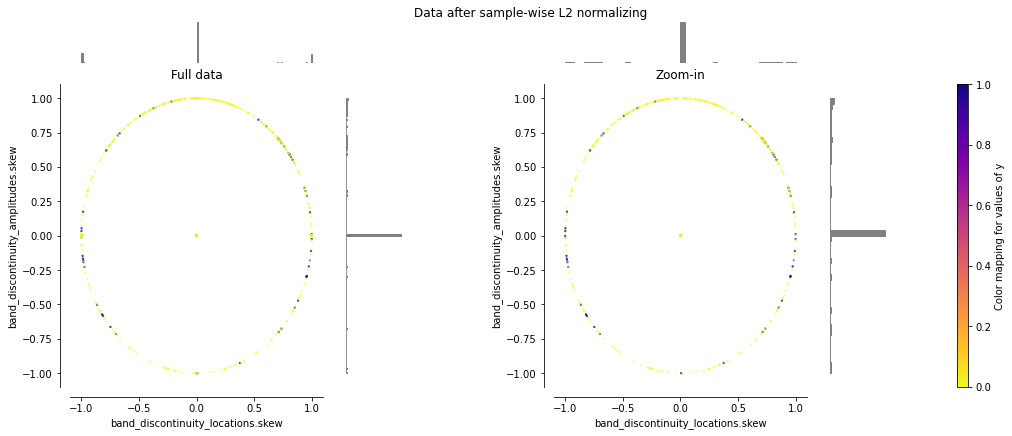

In [142]:
make_plot(8)

## Normalizer
Rescales the vector for each sample to have a unit norm (mapping it to the unit cricle).

In [144]:
make_plot(9)

IndexError: list index out of range